<a href="https://colab.research.google.com/github/Sahlakm/Phishing-Detection/blob/main/Logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# It sets the backend of matplotlib to the 'inline' backend:
import time # calculate time

from sklearn.linear_model import LogisticRegression # algo use to predict good or bad
from sklearn.naive_bayes import MultinomialNB # nlp algo use to predict good or bad

from sklearn.model_selection import train_test_split # spliting the data between feature and target
from sklearn.metrics import classification_report # gives whole report about metrics (e.g, recall,precision,f1_score,c_m)
from sklearn.metrics import confusion_matrix # gives info about actual and predict
from nltk.tokenize import RegexpTokenizer # regexp tokenizers use to split words from text
from nltk.stem.snowball import SnowballStemmer # stemmes words
from sklearn.feature_extraction.text import CountVectorizer # create sparse matrix of words using regexptokenizes
from sklearn.pipeline import make_pipeline # use for combining all prerocessors techniuqes and algos

from PIL import Image # getting images in notebook
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator# creates words colud

from bs4 import BeautifulSoup # use for scraping the data from website

import networkx as nx # for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

import pickle# use to dump model

import warnings # ignores pink warnings
warnings.filterwarnings('ignore')

In [4]:
data1 = pd.read_csv('/gdrive/MyDrive/GRP 12: Project 2020-2024/Dataset/phishing_site_urls.csv')
data1.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [5]:
print(data1.shape)
data1.columns

(549346, 2)


Index(['URL', 'Label'], dtype='object')

In [6]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [7]:
data1.isnull().sum()

URL      0
Label    0
dtype: int64

<Axes: ylabel='Label'>

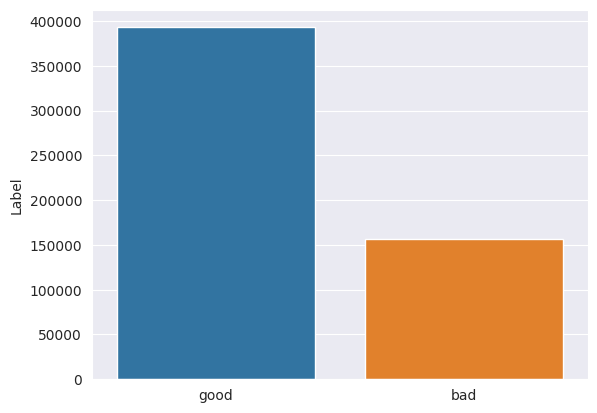

In [8]:
label_counts = pd.DataFrame(data1.Label.value_counts())
sns.set_style('darkgrid')
sns.barplot(x=label_counts.index,y=label_counts.Label)

In [9]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
data1["text_tokenized"] = data1.URL.map(lambda t:tokenizer.tokenize(t))
data1.head()

,URL,Label,text_tokenized
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe..."
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin..."
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int..."
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex..."
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi..."


In [10]:
stemmer = SnowballStemmer("english")
data1['text_stemmed'] = data1['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
data1.head()


,URL,Label,text_tokenized,text_stemmed
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,..."
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin..."
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into..."
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp..."
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide..."


In [11]:
data1['text_sent'] = data1['text_stemmed'].map(lambda l: ' '.join(l))

In [12]:
bad_sites = data1[data1.Label == 'bad']
good_sites = data1[data1.Label == 'good']

In [13]:
import nltk.corpus
from wordcloud import WordCloud, ImageColorGenerator

def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0),
                   title = None, title_size=40, image_color=False):
    STOPWORDS = STOPWORDS = {'the', 'is', 'a', 'an', 'of', 'to', 'in', 'and', 'it', 'that', 'for', 'on', 'with', 'this', 'have', 'at', 'but', 'not', 'which', 'from', 'him', 'her', 'she', 'his', 'hers', 'her', 'its', 'my', 'mine', 'our', 'ours', 'their', 'theirs', 'what', 'when', 'where', 'why', 'how'}
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

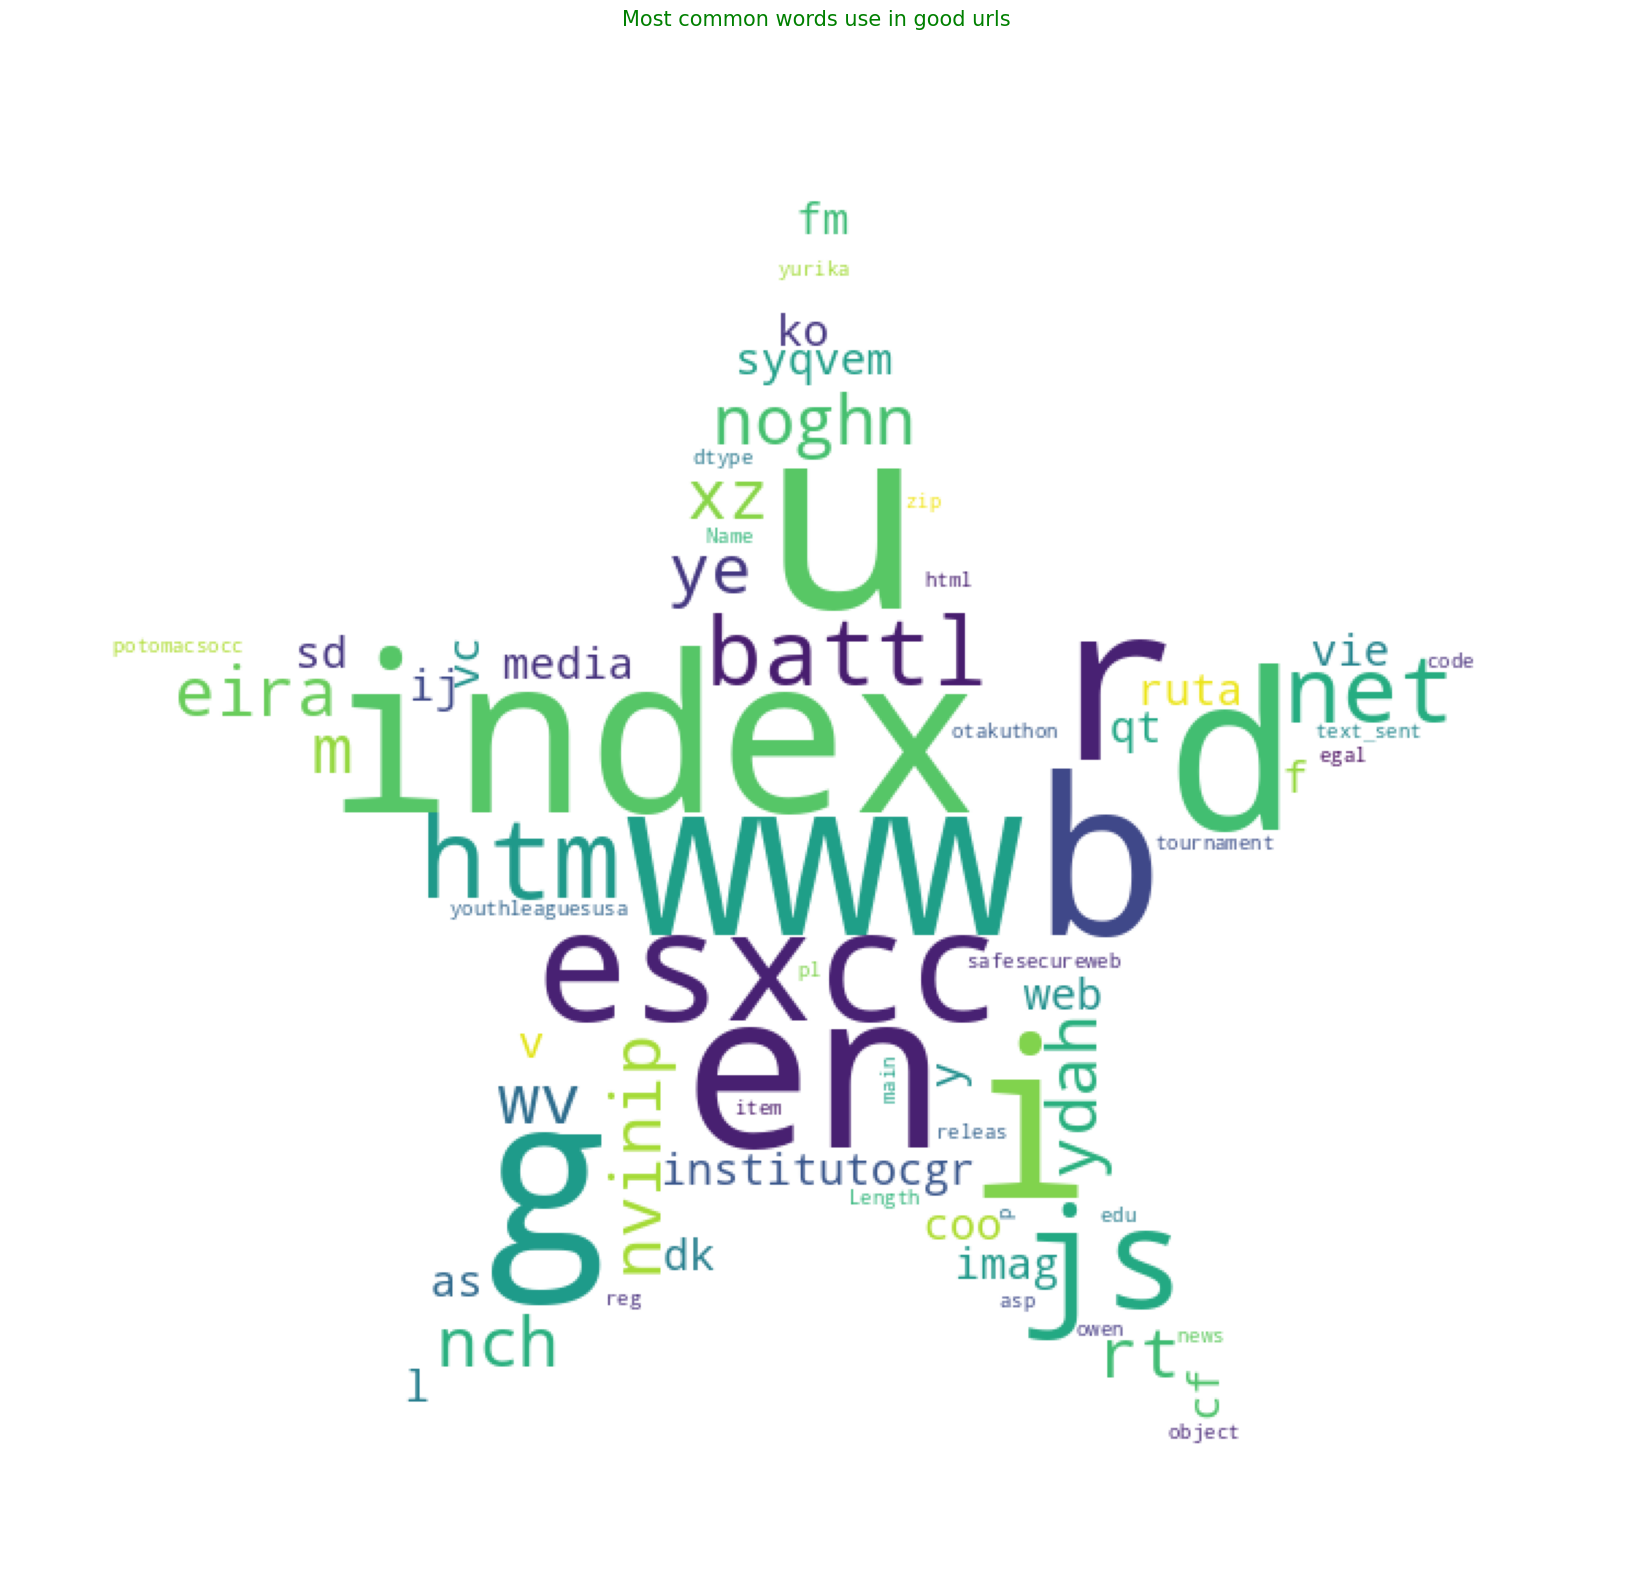

In [14]:
data = good_sites.text_sent
data.reset_index(drop=True, inplace=True)
common_text = str(data)
common_mask = np.array(Image.open('/gdrive/MyDrive/GRP 12: Project 2020-2024/star.jpg'))
plot_wordcloud(common_text, common_mask, max_words=400, max_font_size=120,
               title = 'Most common words use in good urls', title_size=15)

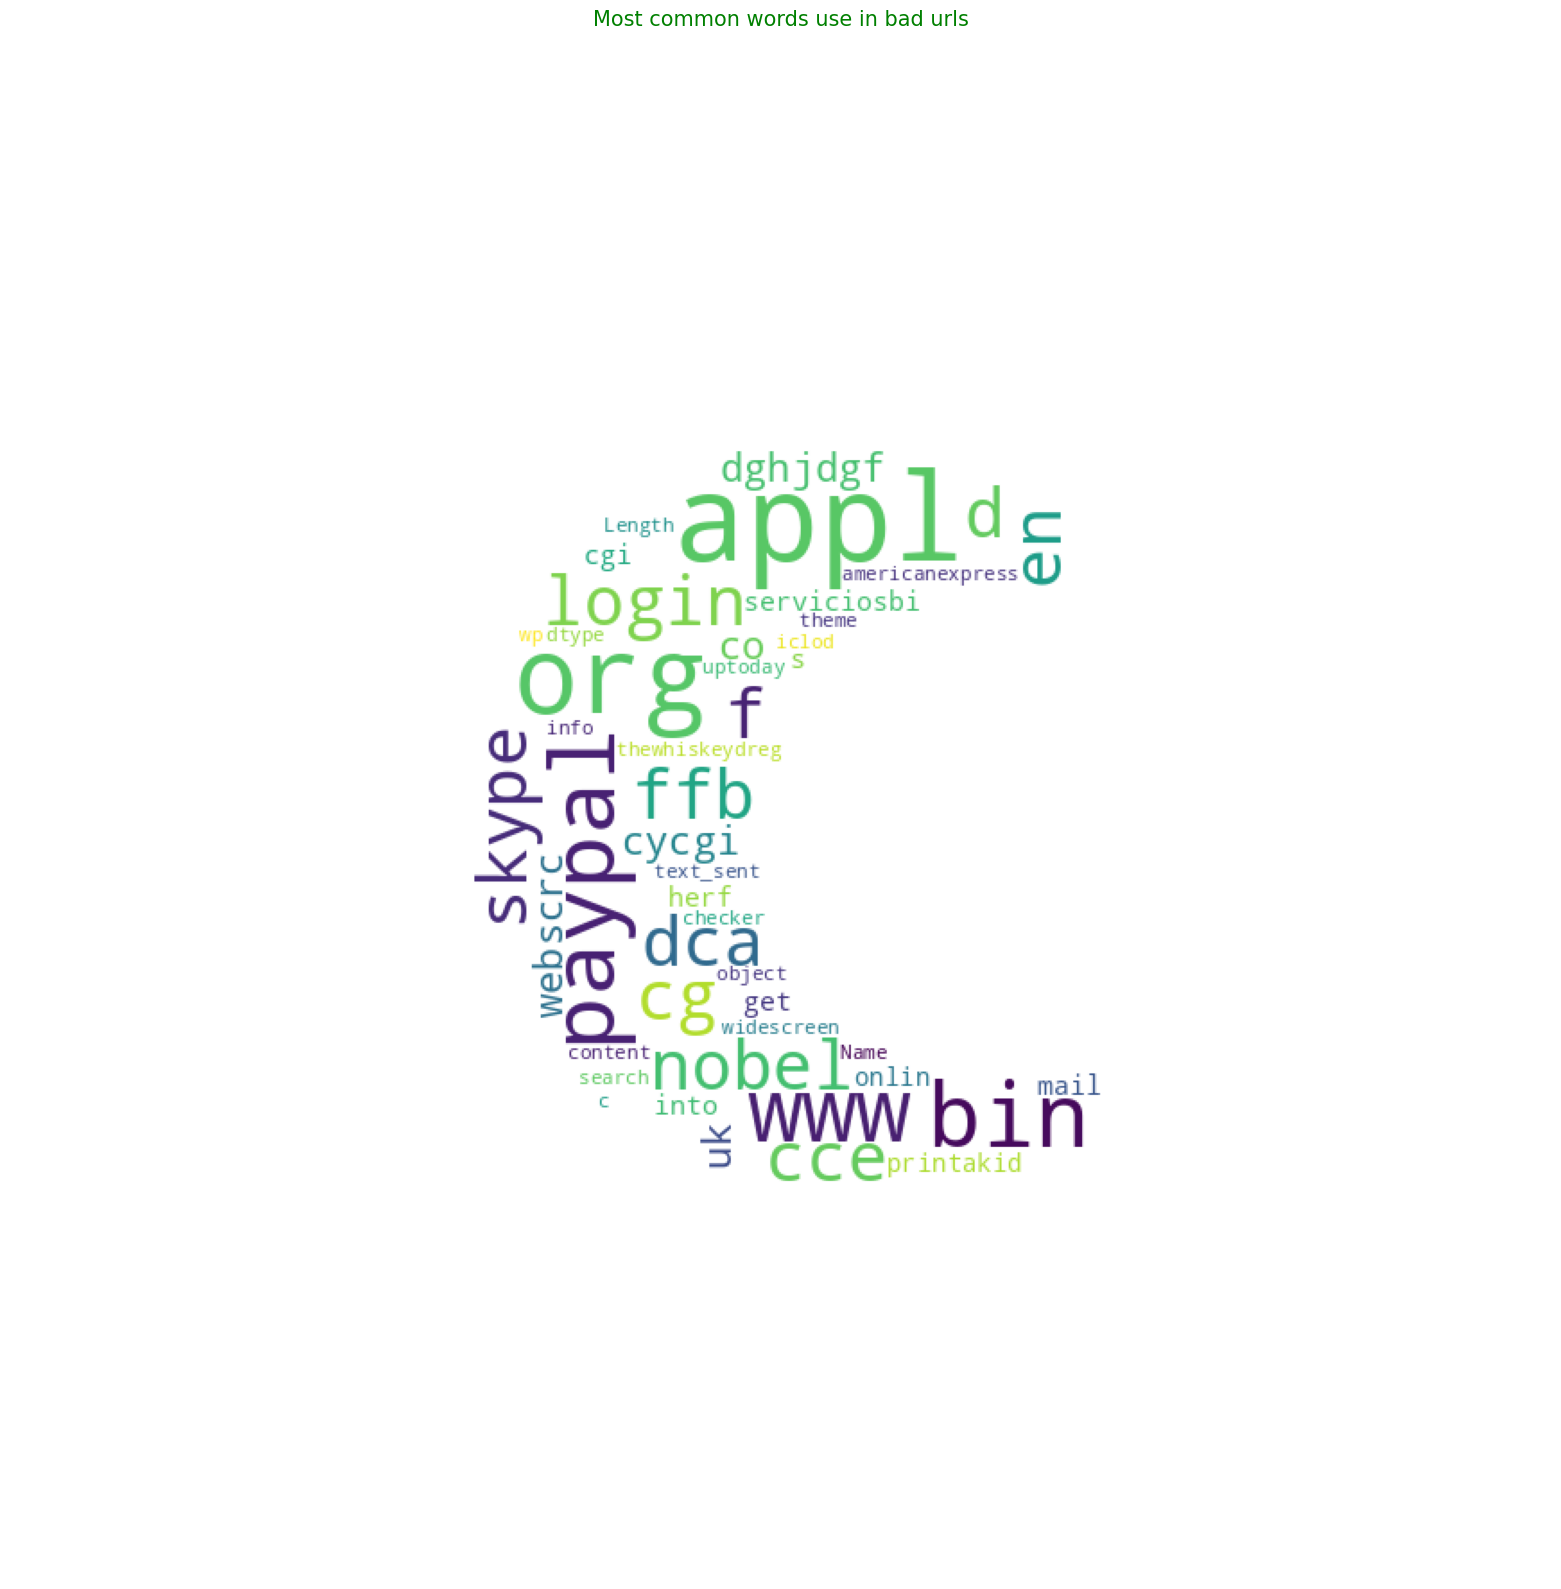

In [15]:
data = bad_sites.text_sent
data.reset_index(drop=True, inplace=True)
common_text = str(data)
common_mask = np.array(Image.open('/gdrive/MyDrive/GRP 12: Project 2020-2024/crescent.webp'))
plot_wordcloud(common_text, common_mask, max_words=400, max_font_size=120,
               title = 'Most common words use in bad urls', title_size=15)

In [16]:
cv = CountVectorizer()
feature = cv.fit_transform(data1.text_sent)
feature[:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [17]:
trainX, testX, trainY, testY = train_test_split(feature, data1.Label)

In [18]:
lr = LogisticRegression()
lr.fit(trainX,trainY)
acc_train_lr = lr.score(trainX,trainY)
acc_test_lr = lr.score(testX,testY)
y_test_lr = lr.predict(testX)
y_train_lr = lr.predict(trainX)

In [19]:
print("LR: Accuracy on training Data: {:.3f}".format(acc_train_lr))
print("LR: Accuracy on test Data: {:.3f}".format(acc_test_lr))

LR: Accuracy on training Data: 0.979
LR: Accuracy on test Data: 0.964


In [21]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())

In [24]:
trainX, testX, trainY, testY = train_test_split(data1.URL, data1.Label)
pipeline_ls.fit(trainX,trainY)
pipeline_ls.score(testX,testY)

0.9668042843516313

Training Accuracy : 0.9811436157948006
Testing Accuracy : 0.9668042843516313

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     36833
        Good       0.99      0.97      0.98    100504

    accuracy                           0.97    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.97      0.97    137337


CONFUSION MATRIX


<Axes: >

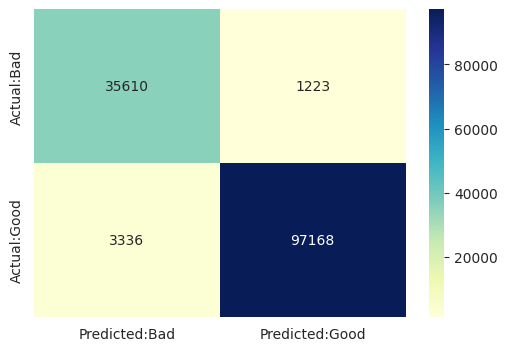

In [25]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [26]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9668042843516313


In [27]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['youtube.com/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
#predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)

['bad' 'bad' 'bad' 'bad']
******************************
['good' 'good' 'good' 'good']
